# The Iris dataset

The Iris dataset is a classic dataset from the 1930s; it is one of the first modern examples of
statistical classification.

The dataset is a collection of morphological measurements of several iris flowers. These measurements will be used to distinguish multiple species of flower. Today, species are identified by their DNA fingerprints, but in the 1930s, DNA's role in genetics had not yet been discovered.

The following four attributes of each plant were measured:
* Sepal length
* Sepal width
* Petal length
* Petal width

In general, the individual numeric measurements are used to describe the data features. These features can be directly measured or computed from intermediate data.

This dataset has four features. Additionally, for each plant, the species is recorded. The problem that needs to be solved is: "given these examples, if a new flower out in the field is found, could a good prediction about its species be made from its measurements?

This is the classification problem: given labeled examples, can be a rule designed to be later applied to other examples?

## Visualization is a good first step

With only four features in the starting example, all two-dimensional projections can be easily ploted on a single page and builded predictions, which then can be extended to large datasets with many more features. Visualizations are excellent in the initial exploratory phase of the analysis as they allow to learn the general features of the problem as well as catch problems that occurred with data collection early.

Each subplot in the following plot shows all points projected into two of the dimensions. It can be seen that there are two large groups. One is of Iris Setosa and another is a mixture of Iris Versicolor and Iris Virginica:

Here is the code to load the dataset:

In [1]:
from sklearn.datasets import load_iris

data = load_iris()
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names
labels = target_names[target]

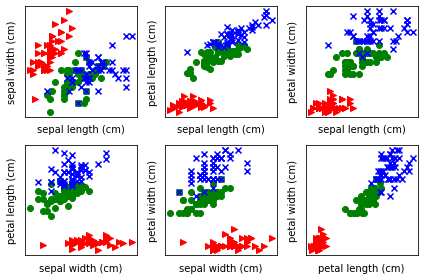

In [2]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 3)
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Set up 3 different pairs of (color, marker)
color_markers = [
    ('r', '>'),
    ('g', 'o'),
    ('b', 'x'),
]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class `t`
        c,marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0])
    ax.set_ylabel(feature_names[p1])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

## Classifying with scikit-learn

Python is an excellent language for machine learning because of its excellent libraries. These objects have the following two essential methods:
* fit(features, labels): This is the learning step and fits the parameters of the model. It takes a list-like object with features and another with labels as arguments.
* predict(features): This method can only be called after fit and returns a prediction for one or more inputs.

## Building the first classification model

If the goal is to separate the three types of flowers, a few suggestions can be immediately made just by looking at the data. For example, petal length seems to be able to separate Iris Setosa from the other two flower species on its own

Intuitively, a simple model can be builded: if the petal width is smaller than about 1, then this is an Iris Setosa flower; otherwise it is either Iris Virginica or Iris Versicolor. Machine learning is when code is written to look for this type of separation automatically.

The problem of recognizing Iris Setosa apart from the other two species was very easy. However, the best cut for distinguishing Iris Virginica from Iris Versicolor cannot be immediately identify. It can even be seen that perfect separation with a simple rule like will be never achieved, if feature X is above a certain value, then A, or else B

Multiple rules in a decision tree can be tried to be combined. It has the further advantage that the model can be simple to interpret.

With scikit-learn, it is easy to learn a decision tree:

In [3]:
from sklearn import tree

tr = tree.DecisionTreeClassifier(min_samples_leaf=10)
tr.fit(features, labels)

DecisionTreeClassifier(min_samples_leaf=10)

That's it. Visualizing the tree requires that it is first written out to a file in dot format and then display it:

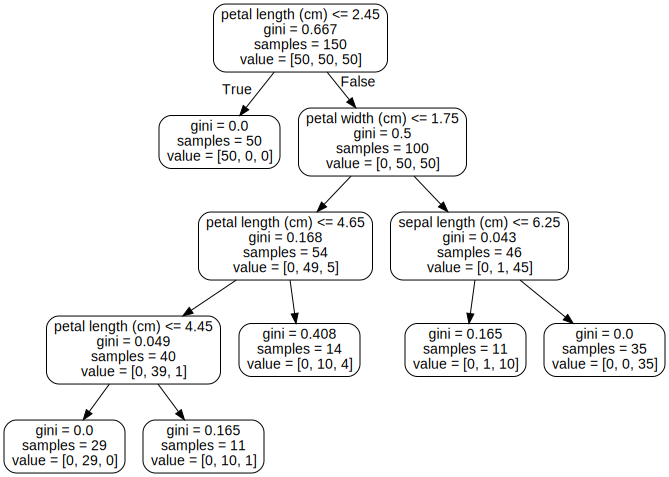

In [4]:
import graphviz

tree.export_graphviz(tr, feature_names=feature_names, rounded=True, out_file='decision.dot')

graphviz.Source(open('./decision.dot').read())

It can be seen that the first split is petal width and results in two nodes, one node where all the samples are of the first class (denoted by [50,0,0]) and the rest of the data ([0,50,50]).

How good is this model? It can be tried out by applying it to the data (using the predict method) and seeing how well it matches with the input:

In [5]:
import numpy as np

prediction = tr.predict(features)
print("Accuracy: {}%".format(np.mean(prediction == labels)*100))

Accuracy: 96.0%


This prints out the accuracy: 96.0 percent

# Evaluation – holding out data and cross-validation

The model discussed in the previous section is a simple model; it achieves 96.0 percent accuracy of the whole data. However, this evaluation is almost certainly overly optimistic. The data was used to define what the tree would look like, and then the same data was used to evaluate the model. Of course, the model will perform well on this dataset as it was optimized to perform well on it. The reasoning is circular.

What it really need to do is estimate the ability of the model to generalize to new instances. To do this, the data are going to be breaked up into two groups: in one group, the model will be trained, and in the other, the one we held out of training will be tested. Its output is as follows:

In [6]:
testing = np.tile([True, False], int(features.shape[0]/2))

training = ~testing

tr = tree.DecisionTreeClassifier(min_samples_leaf=10)
tr.fit(features[training], labels[training])

train_accuracy = np.mean(tr.predict(features[training]) == labels[training])
test_accuracy = np.mean(tr.predict(features[testing]) == labels[testing])

print("Training accuracy was {:.1f}%".format(train_accuracy * 100))
print("Testing accuracy was {:.1f}%".format(test_accuracy * 100))

Training accuracy was 97.3%
Testing accuracy was 93.3%


The result on the training data (which is a subset of the whole data) is better than before. However, what is important to note is that the result for the testing data is lower than that of the training error. While this may surprise an inexperienced machine learner, it is expected that testing accuracy will be lower than the training accuracy.

To understand why, think about how the decision tree works: it defines a series of thresholds on different features. Sometimes it may be very clear where the threshold should be, but there are areas where even a single datapoint can change the threshold and move it up or down.

The accuracy on the training data, the training accuracy, is almost always an overly optimistic estimate of how well your algorithm is doing. The testing accuracy should always be measured and reported, which is the accuracy on a collection of examples that were not used for training.

One possible problem with what we just did is that we only used half the data for training. Ideally, we would like to use all of the data for training and all of the data for testing as well, which is impossible.

A good approximation of this impossible ideal can be achieved via a method called cross-validation. One simple form of cross-validation is leave-one-out cross-validation. An example will be taken out of the training data, learn a model without this example, and then test whether the model classifies this example correctly.

This process is then repeated for all the elements in the dataset:

In [7]:
predictions = []
for i in range(len(features)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    tr.fit(train_features, train_labels)
    predictions.append(tr.predict([features[i]]))
predictions = np.array(predictions)

At the end of this loop, we will have tested a series of models on all the examples and will have obtained a final average result. A series of models on all the examples will have been tested and a final average result will have been obtained. When using cross-validation, there is no circularity problem because each example was tested on a model that was built without taking that datapoint into account. Therefore, the cross-validated estimate is a reliable estimate of how well the models will generalize to new data.

The major problem with leave-one-out cross-validation is that it is now forced to perform more work many times. In fact, a whole new model must be learned for each and every example and this cost will increase as the dataset grows.

Most of the benefits of leave-one-out at a fraction of the cost can be gotten by using k-fold cross-validation, where k stands for a small number. For example, to perform five-fold cross-validation, the data is broken up into five groups, so-called five folds.

A cross-validation schedule allows you to use all the data to estimate whether the methods are doing well. At the end of the cross-validation loop, then use all the data to train a final model.

Although it was not properly recognized when machine learning was starting out as a field, nowadays, it is seen as a very bad sign to even discuss the training accuracy of a classification system. We always want to measure and compare either the error on a held-out dataset or the error estimated using a cross-validation scheme.

# A more complex dataset and the nearest-neighbor classifier

Now look at a slightly more complex dataset. This will include the introduction of a new classification algorithm and a few other ideas.

## Learning about the seeds dataset

Now look at another agricultural dataset, which is still small, but already too large to plot exhaustively on a page as was done with the Iris dataset. There are seven features that are present, which are as follows:
* Area A
* Perimeter P
* Compactness C = 4πA/P²
* Length of kernel
* Width of kernel
* Asymmetry coefficient
* Length of kernel groove

There are three classes corresponding to three wheat varieties: Kama, Rosa and Canadian. Unlike the Iris dataset, which was collected in the 1930s, this is a very recent dataset and its features were automatically computed from digital images.

This is how image pattern recognition can be implemented: just take images, in digital form, compute a few relevant features from them, and use a generic classification system. For the moment, just work with the features that are given.

UCI Machine Learning Dataset Repository:

The University of California at Irvine (UCI) maintains an online repository of machine learning datasets (at the time of writing, they list 233 datasets). The repository is available online at https://archive.ics.uci.edu/ml/.

## Features and feature engineering

One interesting aspect of these features is that the compactness feature is not actually a new measurement, but a function of the previous two features: area and perimeter. Trying to create new features is generally called feature
engineering. It is sometimes seen as less glamorous than algorithms, but it often matters more for performance (a simple algorithm on well-chosen features will perform better than a fancy algorithm on not-so-good features).

In this case, the original researchers computed the compactness, which is a typical feature for shapes. This feature will have the same value for two kernels, one of which is twice as big as the other one, but with the same shape. However, it will have different values for kernels that are very round (when the feature is close to 1) when compared to kernels that are elongated (when the feature is closer to zero).

The goals of a good feature are to simultaneously vary with what matters (the desired output) and be invariant with what does not. In practice, it might be hard to achieve both objectives perfectly, but the goal is to approximate this ideal.

Background knowledge will be needed to design good features. When possible, use the knowledge of the problem to design a specific feature or to select, from literature, the ones that are more applicable to the data at hand.

Even before data is obtained, it is a must to decide which data is worthwhile to collect. Then, hand all the features to the machine to evaluate and compute the best classifier.

A natural question is whether good features can be selected automatically. For the small problems, it does not make sense to use feature selection, but if there are thousands of features, then throwing out most of them might make the rest of the process much faster.

## Nearest neighbor classification

For use with this dataset, a new classifier will be introduced: the nearest neighbor classifier. The nearest neighbor classifier is very simple. When classifying a new element, this looks at the training data. For the object that is closest to it, its nearest neighbor. Then, it returns its label as the answer. Notice that this model performs perfectly on its training data! For each point, its closest neighbor is itself, and so its label matches perfectly (unless two examples with different labels have exactly the same feature values, which will indicate that the features are not very descriptive). Therefore, it is essential to test the classification using a cross-validation protocol.

The nearest neighbor method can be generalized to look not at a single neighbor, but to multiple ones, and can take a vote amongst the neighbors. This makes the method more robust than outliers or mislabeled data.

To use scikit-learn's implementation of nearest neighbor classification, start by importing the KneighborsClassifier object from the sklearn.neighbors submodule:

In [8]:
import urllib

def load_dataset(dataset_name):
    '''
    data = load_dataset(dataset_name)
    Load a given dataset
    Returns
    -------
    data : dictionary
    '''
    features = []
    target = []
    target_names = set()
    ifile = urllib.request.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt")
    for line in ifile:
        tokens = line.decode('utf-8').strip().split('\t')
        features.append([float(tk) for tk in list(filter(None, tokens[:-1]))])
        target.append(tokens[-1])
        target_names.add(tokens[-1])
    features = np.array(features)

    target_names = list(target_names)
    target_names.sort()
    target = np.array([target_names.index(t) for t in target])
    return {
        'features': features,
        'target_names': target_names,
        'target': target,
    }

In [9]:
feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]
data = load_dataset('seeds')
features = data['features']
target = data['target']

In [10]:
from sklearn.neighbors import KNeighborsClassifier

Now instantiate a classifier object. In the constructor, the number of neighbors to consider is specified, as follows:

In [11]:
knn = KNeighborsClassifier(n_neighbors=1)

If we do not specify the number of neighbors, it defaults to 5, which is often a good choice for classification, but we stick with 1 as it's very easy to think about.

Cross-validation will be used (of course) to look at our data. The scikit-learn module also makes this easy:

In [12]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=5, shuffle=False)
means = []
for training, testing in kf.split(features):
    # A model is learnt for this fold with `fit` and then apply it to the
    # testing data with `predict`:
    knn.fit(features[training], target[training])
    prediction = knn.predict(features[testing])
    # np.mean on an array of booleans returns fraction
    # of correct decisions for this fold:
    curmean = np.mean(prediction == target[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 83.8%


Using five folds for cross-validation, for this dataset, with this algorithm, the accuracy is 83.8 percent. As discussed in the earlier section, the cross-validation accuracy is lower than the training accuracy, but this is a more credible estimate of the performance of the model.

## Looking at the decision boundaries

Now examine the decision boundaryies. In order to plot these on paper, simplify and look at only two dimensions:

In [13]:
knn.fit(features[:, [0, 2]], target)

KNeighborsClassifier(n_neighbors=1)

Call predict on a grid of feature values (1000 by 1000 points):

In [14]:
y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
X = np.linspace(x0, x1, 1000)
Y = np.linspace(y0, y1, 1000)
X, Y = np.meshgrid(X, Y)
C = knn.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)

Now, plot the decision boundaries:

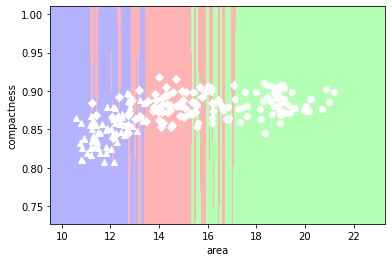

In [15]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
fig, ax = plt.subplots()
ax.scatter(features[:, 0], features[:, 2], c=target, cmap=cmap)
for lab, ma in zip(range(3), "Do^"):
    ax.plot(features[target == lab, 0], features[target == lab, 2], ma, c=(1., 1., 1.), ms=6)
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[2])
ax.pcolormesh(X, Y, C, cmap=cmap)
plt.show()

Kama examples are shown as diamond, Rosa seeds as circles, and Canadian seeds as triangles. The problem is that the x axis (area) ranges from 10 to 22, while the y axis (compactness) ranges from 0.75 to 1.0. This means that a small change in x is actually much larger than a small change in y. So, when the distance between points is computed, for the most part, only take the x axis into account. This is also a good example of why it is a good idea to visualize the data and look for red flags or surprises.

In previous step, it shown that lengths, areas, and dimensionless quantities have been summing up, mixing up the units (which is something that never want to do in a physical system). There are many solutions to this problem; a simple one is to normalize to z-scores. The z-score of a value is how far away from the mean it is, in units of standard deviation. It comes down to this operation:

f' = (f - μ)/σ

In this formula, f is the old feature value, f' is the normalized feature value, μ is the mean of the feature, and σ is the standard deviation. Independent of what the original values were, after z-scoring, a value of zero corresponds to the training mean, positive values are above the mean, and negative values are below it.

The scikit-learn module makes it very easy to use this normalization as a preprocessing step. Just start by importing both the pipeline and the feature scaling classes as follows:

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Now, combine them:

In [17]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

The Pipeline constructor takes a list of pairs, (str, classifier). Advanced usage of the object uses these names to refer to different steps.

After normalization, every feature is in the same units (technically, every feature is now dimensionless; it has no units) and it enables to mix dimensions more confidently. In fact, now run the nearest neighbor classifier, the accuracy is 84 percent, estimated with the same five-fold cross-validation code shown previously!

In [18]:
kf = model_selection.KFold(n_splits=5, shuffle=False)
means = []
for training, testing in kf.split(features):
    # A model is learnt for this fold with `fit` and then apply it to the
    # testing data with `predict`:
    classifier.fit(features[training], target[training])
    prediction = classifier.predict(features[testing])
    # np.mean on an array of booleans returns fraction
    # of correct decisions for this fold:
    curmean = np.mean(prediction == target[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 84.8%


Look at the decision space again in two dimensions:

In [19]:
classifier.fit(features[:, [0, 2]], target)

Pipeline(steps=[('norm', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

In [20]:
y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
X = np.linspace(x0, x1, 1000)
Y = np.linspace(y0, y1, 1000)
X, Y = np.meshgrid(X, Y)
C = classifier.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)

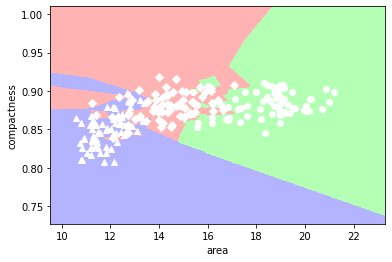

In [21]:
fig, ax = plt.subplots()
ax.scatter(features[:, 0], features[:, 2], c=target, cmap=cmap)
for lab, ma in zip(range(3), "Do^"):
    ax.plot(features[target == lab, 0], features[target == lab, 2], ma, c=(1., 1., 1.), ms=6)
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[2])
ax.pcolormesh(X, Y, C, cmap=cmap)
plt.show()

The boundaries are now different and it can be seen that both dimensions make a difference to the outcome. In the full dataset, everything is happening on a seven-dimensional space, which is very hard to visualize, but the same principle applies; while a few dimensions are dominant in the original data, after normalization, they are all given the same importance.

# Which classifier to use

So far, two classical classifiers have been tried, namely the decision tree and the nearest neighbor classifier. Scikit-learn supports many more, but it does not support everything that has ever been proposed in academic literature. Thus, one may be left wondering: which one should be used? Is it even important to learn about all of them?

In many cases, knowledge of the dataset may help to decide which classifier has a structure that best matches the problem. However, there is a very good study by Manuel Fernández-Delgado and his colleagues titled, Do we Need Hundreds of Classifiers to Solve Real World Classification Problems? This is a very readable, very practically-oriented study, where the authors conclude that there is actually one classifier which is very likely to be the best (or close to the best) for a majority of problems, namely random forests.

What is a random forest? As the name suggests, a forest is a collection of trees. How to obtain many trees from a single dataset? If try to call the methods that is used before several times, it will find that it will get the exact same tree every time. The trick is to call the method several times with different random variations of the
dataset. In particular, each time, take a fraction of the dataset and a fraction of the features. Thus, each time, there is a different tree. At classification time, all the trees vote and a final decision is reached. There are many different parameters that determine all the minor details, but only one is relevant, namely the number of trees that will be used. The default in scikit-learn is 10 trees. Unless the dataset is very large such that memory usage become problematic, increasing this value is often advantageous:

In [22]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(n_estimators=100)
predict = model_selection.cross_val_predict(rf, features, target)
print("RF accuracy: {:.1%}".format(np.mean(predict == target)))

RF accuracy: 89.0%


On this dataset, the result is about 89 percent (it may be slightly different when it is run, as they are random forests).

Another big advantage of random forests is that, since they are based on decision trees, ultimately they only perform binary decisions based on feature thresholds. Thus, they are invariant when features are scaled up or down.